# Importations

In [1]:
# from sklearnex import patch_sklearn
# patch_sklearn()

from src.utils import read_split_csv
from src.mlp.mlp import VPowerDataset, train_save
from src.mlp.mlp_plot import plot_learning_curve
from src.mlp.scaling_uncertainty import store_stats, data_normalization
import torch
import random

print("Torch Version", torch.__version__)

Torch Version 1.11.0


In [2]:
torch.cuda.is_available()

True

if not, in shell : 

sudo rmmod nvidia_uvm && sudo modprobe nvidia_uvm

# Load data
(quadricoptere dataset)

In [20]:
# avec données ou on garde les vols entiers 
datasets = read_split_csv("/App/Data/split_flight/")#, engine="python")

# create validation set 
# select n flights from each payload 
L = []
nf = 6
for n, g in datasets["train"].groupby("payload"):
    print(n)
    print(random.sample(set(g.flight), nf))
    L.extend(random.sample(set(g.flight), nf))

datasets["val"] = datasets["train"].loc[datasets["train"].flight.isin(L)]
datasets["train"] = datasets["train"].drop(index=datasets["val"].index)

print(datasets["train"].payload.value_counts(normalize=True))
print(datasets["test"].payload.value_counts(normalize=True))
totallen = datasets["train"].size + datasets["test"].size
print(datasets["train"].size/totallen, datasets["test"].size/totallen)

train.csv
test.csv
0
[279, 150, 124, 131, 5, 80]
250
[135, 210, 23, 20, 142, 261]
500
[200, 95, 166, 100, 126, 107]
0      0.341644
500    0.336633
250    0.321723
Name: payload, dtype: float64
0      0.359352
500    0.331879
250    0.308769
Name: payload, dtype: float64
0.899192005710207 0.10080799428979301


In [4]:
datasets = read_split_csv("/App/Data/split_quad/")#, engine="python")
datasets["val"]

val.csv
train.csv


test.csv
lourd.csv


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
109923,2019-07-03 03:10:00,150,35.50,2.8,238.0,22.759777,23.505444,-79.782777,40.458953,365.169441,...,-0.076906,0.335496,-0.143232,-9.869870,12,0,100,R1,534.978656,537.998819
91658,2019-06-29 12:40:00,136,78.60,9.4,4.0,21.084534,26.065914,-79.782571,40.458586,290.375622,...,-0.082310,-1.529684,0.423300,-9.976319,8,250,25,R1,549.587645,526.000169
200354,2019-07-24 16:28:00,229,62.60,10.5,204.0,22.172565,18.448116,-79.782210,40.458218,315.845911,...,0.015051,-1.633767,0.061935,-9.457129,10,0,50,R1,409.042066,432.243997
122937,2019-07-03 16:35:00,162,3.10,0.9,265.0,21.716820,24.189297,-79.782738,40.458992,276.467557,...,-0.054514,0.133585,-0.133318,-10.589297,8,500,75,R1,525.314597,536.179872
164684,2019-07-15 08:05:00,195,112.60,2.2,128.0,23.306925,17.772215,-79.782766,40.459063,367.520864,...,0.018428,0.267958,-0.178819,-8.603159,8,250,100,R1,414.215676,420.793236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119371,2019-07-03 16:10:00,158,4.20,1.0,70.0,22.375399,21.795813,-79.782763,40.458980,270.231115,...,0.012899,0.072653,0.035458,-9.965531,12,250,75,R1,487.689996,544.146733
228319,2019-08-05 18:00:00,252,53.61,2.8,212.0,21.711811,26.304468,-79.781380,40.459499,345.136230,...,-0.000584,-0.393476,0.177744,-9.913366,12,500,75,R1,571.117643,586.617433
255344,2019-10-24 09:45:00,277,72.01,9.0,14.0,21.670494,21.390272,-79.782571,40.458526,293.235121,...,-0.107946,-0.764824,0.548552,-9.283231,10,500,25,R1,463.537766,460.171522


In [21]:
# remove columns 
cols_ignored = ["flight"]
# cols_ignored = ["time_start","battery_voltage","battery_current", "altitude","speed","route", "position_x", "position_y", "flight"]
# cols_redundent = ["linear_acceleration_x", "velocity_y", "power"]
cols_redundent = []
target = ["power"]
# target = ["power_smoothed"]

datasets_cleaned = dict()
for k in datasets.keys():
    datasets_cleaned[k] = datasets[k].drop(columns = cols_ignored + cols_redundent) # + target)

datasets_cleaned["train"]

,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,payload,power
index,,,,,,,,,,,,,,,,,
1531,0.00,1.1,178.0,268.830833,-0.000779,0.005692,0.298475,0.954400,-0.009233,0.007667,-0.001621,-0.001778,0.005457,-0.113653,-9.802392,0,10.121494
1532,0.10,1.2,173.0,268.825543,-0.000763,0.005683,0.298431,0.954414,-0.014337,0.012726,-0.002207,0.000437,0.002690,-0.122272,-9.806426,0,656.341326
1533,0.20,1.2,169.0,268.826959,-0.000989,0.005932,0.298317,0.954448,-0.009611,0.013629,0.005904,0.004494,0.025825,-0.120708,-9.803435,0,40.699311
1534,0.40,1.2,160.0,268.823417,-0.001039,0.005962,0.298334,0.954442,-0.009544,0.013195,-0.008197,0.002018,0.003247,-0.089019,-9.812296,0,6.626053
1535,0.60,1.2,153.0,268.824807,-0.000956,0.005893,0.298380,0.954428,-0.010878,0.013461,-0.020062,0.011857,0.004577,-0.121922,-9.797800,0,32.103697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257756,116.11,2.6,180.0,270.146941,0.020484,0.017983,0.011347,0.999564,0.038757,-0.047724,0.003752,-0.003594,0.004261,-0.372928,-9.812629,0,73.386768
257757,116.30,2.6,180.0,270.168574,0.020504,0.017502,0.011056,0.999575,0.030060,-0.037571,-0.042004,0.011623,0.044291,-0.361034,-9.817332,0,82.214738
257758,116.40,2.8,181.0,270.164794,0.020545,0.017249,0.011084,0.999579,0.037211,-0.038548,-0.009871,-0.018115,-0.005242,-0.279831,-9.797699,0,85.595864


## Data scaling

Data scaling description:
* For the time feature `time` we perform a `zeromax` scaling using the maximum time over training set. 
* The flight number is not scaled
* The rest input features and the target are `standardized` (Z-scaling).

In [22]:
target = "power"
# target = "power_smoothed"
input_features = list(datasets_cleaned["train"].columns)
input_features.remove(target)
print(input_features)

# folder to store models and stats
model_dir = "/App/code_preparation/baselines"

['time', 'wind_speed', 'wind_angle', 'position_z', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'velocity_x', 'velocity_z', 'angular_x', 'angular_y', 'angular_z', 'linear_acceleration_y', 'linear_acceleration_z', 'payload']


In [23]:
train_data = datasets_cleaned["train"]

# store stats computed on training data so we can use them for inference
means, stds = store_stats(train_data, model_dir)
# time max for max scaling
time_max = train_data.time.max()

In [24]:
data_all_norm = {}
for k in datasets_cleaned.keys():
    data_all_norm[k] = data_normalization(data=datasets_cleaned[k], means=means, stds=stds, time_max=time_max)

In [25]:
train_norm = data_normalization(data=train_data, means=means, stds=stds, time_max=time_max)

dev_in_data = datasets_cleaned["test"]
dev_in_norm = data_normalization(data=dev_in_data, means=means, stds=stds, time_max=time_max)

train_norm

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power,velocity_x,velocity_z,wind_angle,wind_speed,time
index,,,,,,,,,,,,,,,,,
1531,-0.000217,-0.009371,-0.111487,-0.313563,-0.012107,1.096860,0.267652,0.429798,0.451773,-1.208152,-1.427372,-4.543031,0.311383,-0.229267,1.244404,-1.260015,0.000000
1532,-0.004594,0.001585,-0.121082,-0.331652,-0.019854,1.096901,0.267959,0.429633,0.451713,-1.208152,-1.427536,1.290405,0.299957,-0.226260,1.197461,-1.230709,0.000360
1533,0.055952,0.021647,-0.040842,-0.328370,-0.014111,1.097004,0.263668,0.434621,0.451556,-1.208152,-1.427492,-4.267004,0.310536,-0.225724,1.159906,-1.230709,0.000721
1534,-0.049302,0.009400,-0.119149,-0.261866,-0.031125,1.096987,0.262728,0.435225,0.451580,-1.208152,-1.427603,-4.574584,0.310686,-0.225982,1.075408,-1.230709,0.001441
1535,-0.137858,0.058064,-0.114538,-0.330917,-0.003290,1.096945,0.264290,0.433838,0.451643,-1.208152,-1.427559,-4.344597,0.307700,-0.225824,1.009687,-1.230709,0.002162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257756,0.039886,-0.018351,-0.115633,-0.857682,-0.031766,1.232565,0.670156,0.676039,0.059265,-1.208152,-1.386362,-3.971934,0.418817,-0.262183,1.263182,-0.820425,0.418414
257757,-0.301634,0.056905,0.023203,-0.832722,-0.040798,1.232600,0.670545,0.666422,0.058867,-1.208152,-1.385688,-3.892244,0.399347,-0.256150,1.263182,-0.820425,0.419099
257758,-0.061793,-0.090169,-0.148591,-0.662308,-0.003095,1.232609,0.671313,0.661344,0.058905,-1.208152,-1.385806,-3.861723,0.415357,-0.256730,1.272570,-0.761813,0.419459


In [26]:
train_norm.shape

(157471, 17)

In [27]:
train_ds = VPowerDataset(data=train_norm,
                         input_features=input_features,
                         target=target)
val_ds = VPowerDataset(data=dev_in_norm,
                       input_features=input_features,
                       target=target)
                       
train_ds.norm_df.describe()

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power,velocity_x,velocity_z,wind_angle,wind_speed,time
count,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,1.574710e+05,157471.000000,1.574710e+05,157471.000000
mean,-1.200249e-17,-8.968024e-19,-1.804885e-18,1.540289e-15,-5.060790e-14,3.898552e-17,1.826544e-16,1.866251e-16,2.707328e-18,-5.920024e-17,2.802248e-12,7.933193e-14,-1.405645e-15,-2.999719e-15,1.201592,-9.962967e-17,0.280107
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.176331
min,-1.700317e+01,-1.817536e+01,-6.572921e+00,-8.139674e+00,-2.475682e+01,-1.770859e+00,-4.829027e+00,-5.277319e+00,-1.323258e+00,-1.208152e+00,-1.732935e+00,-4.646212e+00,-1.264858e+01,-2.620231e+00,-0.426784,-1.582381e+00,0.000000
25%,-4.851473e-01,-2.988375e-01,-3.584707e-01,-5.085375e-01,-3.314919e-01,-1.038935e+00,-3.877138e-01,-4.076773e-01,-8.590064e-01,-1.208152e+00,-7.902067e-01,-4.609347e-01,-4.013072e-01,-7.820892e-01,0.249202,-8.204247e-01,0.133694
50%,5.594081e-03,3.487813e-03,-1.161990e-01,-2.977290e-02,2.101384e-02,3.275158e-01,1.559256e-01,1.114626e-01,1.308250e-01,6.083863e-03,-1.231809e-02,2.176834e-02,1.739734e-01,-6.395794e-02,1.357069,-2.049986e-01,0.267748
75%,4.935833e-01,3.143854e-01,1.460960e-01,4.771112e-01,4.029056e-01,8.264948e-01,4.546513e-01,4.541409e-01,1.337071e+00,1.220320e+00,8.699965e-01,5.459683e-01,4.251406e-01,6.355579e-01,1.967334,6.741815e-01,0.405766
max,2.257442e+01,1.401369e+01,7.404176e+00,9.788741e+00,8.102100e+00,1.233865e+00,7.519717e+00,5.814902e+00,1.410763e+00,1.220320e+00,1.917889e+00,3.983697e+00,2.422740e+01,3.126359e+00,2.943759,3.722006e+00,1.000000


# Model training
Trains a certain number of models with the same architecture but there will be different initilizations. Saves them in *model_dir*. 

In [29]:
# device = "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device :", device)
imin = 1
imax = 20

models_hs = train_save(imin, imax, model_dir, device, train_ds, val_ds, input_features, n_epochs=25)

device : cuda
Epoch 0/25
Average train loss: 1.0496754266998984
Average val loss: 0.8133993695179621
Val MSE: 1.0585697657532163
Val MAE: 0.6931239697668288
Saved to /App/code_preparation/baselines/member_1//best_model.pth
Epoch 1/25
Average train loss: 0.750286555522448
Average val loss: 0.6288490518927574
Val MSE: 0.8069362805949317
Val MAE: 0.5505660855107837
Saved to /App/code_preparation/baselines/member_1//best_model.pth
Epoch 2/25
Average train loss: 0.6570627809344948
Average val loss: 0.575152108238803
Val MSE: 0.8212436967425876
Val MAE: 0.569404348731041
Epoch 3/25
Average train loss: 0.6302740628069098
Average val loss: 0.5695221606228087
Val MSE: 0.8470006502336926
Val MAE: 0.5474070062239965
Saved to /App/code_preparation/baselines/member_1//best_model.pth
Epoch 4/25
Average train loss: 0.622531546400739
Average val loss: 0.6128122078047858
Val MSE: 0.719767936401897
Val MAE: 0.5637936062282987
Epoch 5/25
Average train loss: 0.6500496806262376
Average val loss: 0.56676077

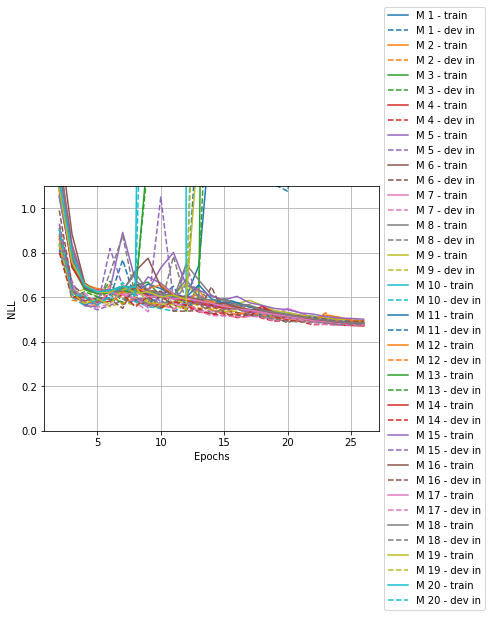

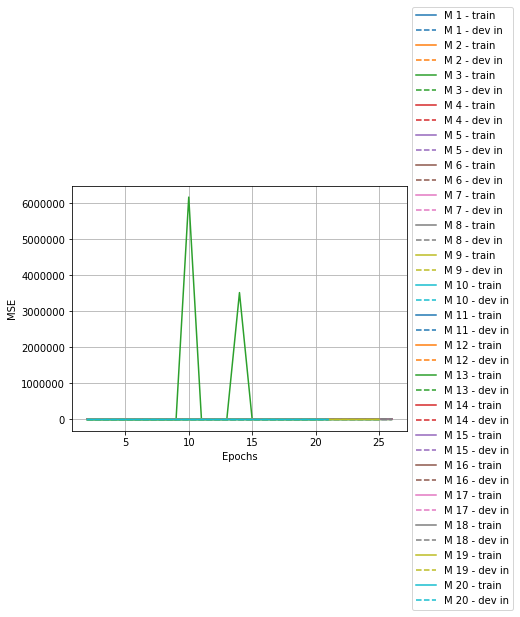

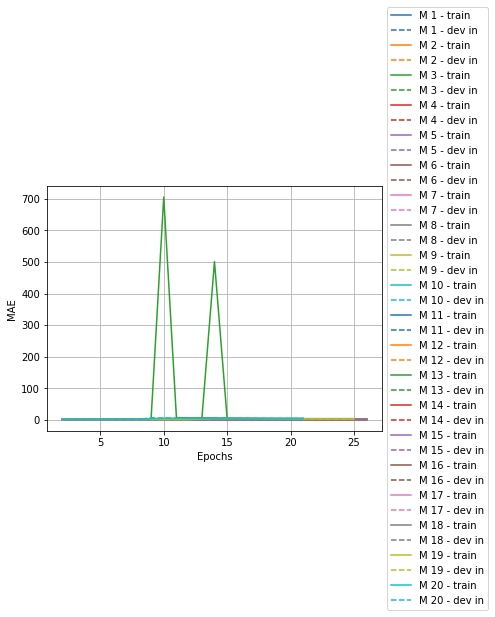

In [30]:
plot_learning_curve(history=models_hs,
                    metric="loss",
                    label="NLL",
                    ylims=(0.0, 1.1)
                    )
plot_learning_curve(history=models_hs,
                    metric="mse",
                    label="MSE",
                    # ylims=(0.01, 0.2)
                    )
plot_learning_curve(history=models_hs,
                    metric="mae",
                    label="MAE",
                    # ylims=(0.1, 0.35)
                    )